In [1]:
import os
import pandas as pd
import numpy as np
import functools
from matplotlib import pylab as plt
from matplotlib.pyplot import figure

In [15]:
DATA_DIRECTORY = "../data"
country = 'us'
policies = ["control_sample_nat", "control_sample_bridged", "geneva_def", "intang_def", "nordvpn_obfs_bridged", "tor", "torbrowser", "cloudflare_new", "geneva+cloudflare"]

In [16]:
# Convert .pcaps to .csvs
for policy in policies:
    df = pd.read_csv(f'{DATA_DIRECTORY}/{country}_{policy}/experiments.csv')
    for experiment_code in df.experiment_code:
       pcap_path = f'{DATA_DIRECTORY}/{country}_{policy}/pageload_pcap_{experiment_code}.pcap'
       if os.path.exists(pcap_path) and not os.path.exists(f'{DATA_DIRECTORY}/{country}_{policy}/csv_{experiment_code}.csv'):
           # do stuff
           code = os.system(f'tshark -2 -r {pcap_path} -T fields -e frame.time_epoch -e ip.id -e ip.ttl -e ip.dst -e ip.src -e tcp.srcport -e tcp.dstport -e tcp.len -e tcp.stream -e tcp.seq -e tcp.window_size -e tcp.ack -e tcp.flags -e tcp.flags.reset -e tcp.flags.str -e tcp.analysis.initial_rtt -e tcp.analysis.ack_rtt -e tcp.options.timestamp.tsval -e tcp.options.timestamp.tsecr -e tcp.options.timestamp -e http.host -e http.response.code -e http.user_agent -e http.location -o "tls.keylog_file: {DATA_DIRECTORY}/{country}_{policy}/keylogfile_{experiment_code}.log" > {DATA_DIRECTORY}/{country}_{policy}/csv_{experiment_code}.csv')
           if code != 0:
               print("Error :(")
               break


In [17]:
excluded_codes = {}
for policy in policies:
    excluded_codes[policy] = []
    df = pd.read_csv(f'{DATA_DIRECTORY}/{country}_{policy}/experiments.csv')
    for experiment_code in df.experiment_code:
        if not os.path.exists(f'{DATA_DIRECTORY}/{country}_{policy}/csv_{experiment_code}.csv'):
            excluded_codes[policy].append(experiment_code)
excluded_codes

{'control_sample_nat': [],
 'control_sample_bridged': [],
 'geneva_def': [],
 'intang_def': [],
 'nordvpn_obfs_bridged': [],
 'tor': [],
 'torbrowser': [],
 'cloudflare': []}

In [18]:
dfs = {}
for policy in policies:
    df = pd.read_csv(f'{DATA_DIRECTORY}/{country}_{policy}/experiments.csv')
    df = df[~(df.experiment_code.isin(excluded_codes[policy]))]
    df.drop_duplicates(subset='experiment_code',inplace=True)
    irtt_avgs = []
    ack_rtt_avgs = []
    ack_rtt_weighted_avgs = []
    num_streams = []
    num_packets = []
    crude_latency = []
    ack_rtt_sums = []
    ack_rtt_total_avgs = []
    print(policy)
    for experiment_code in df.experiment_code:
        data = pd.read_csv(
            f"{DATA_DIRECTORY}/{country}_{policy}/csv_{experiment_code}.csv",
            delimiter="\t",
            names=(
                "time_epoch ipid ipttl dstip srcip tcpsrcport tcpdstport tcplen tcpstream tcpseq tcpwindowsize tcpack tcpflags tcpflagsrst tcpflagsstr "
                "initial_rtt ack_rtt tsval tsecr tcptimestamp host code user_agent location"
            ).split(),
        )
        tcpdata = data[(~data.tcpstream.isnull())]
        streamarr = []
        for streamid in tcpdata.tcpstream.unique():
            streampackets = tcpdata[(tcpdata.tcpstream == streamid)][
                "time_epoch tcpstream dstip srcip tcpsrcport tcpdstport tcpseq tcpflagsrst tcpflagsstr initial_rtt ack_rtt tsval tsecr".split()
            ]
            streaminfo = {
                "streamid": streamid,
                "time_epoch_start": streampackets["time_epoch"].iloc[0],
                "time_epoch_end": streampackets["time_epoch"].iloc[-1],
                "num_packets":streampackets["tcpstream"].count(),
                "ip1": streampackets["srcip"].iloc[0],
                "ip2": streampackets["dstip"].iloc[0],
                "port1": streampackets["tcpsrcport"].iloc[0],
                "port2": streampackets["tcpdstport"].iloc[0],
                "initial_rtt": streampackets[(~streampackets.initial_rtt.isnull())]["initial_rtt"].iloc[0]
                if streampackets[(~streampackets.initial_rtt.isnull())]["initial_rtt"].size > 0
                else None,
                "ack_rtt_avg": streampackets.ack_rtt.mean(),
                "ack_rtt_sum": streampackets.ack_rtt.sum(),
                "num_rst": streampackets.tcpflagsrst.sum(),
            }
            streamarr.append(streaminfo)
        streamdata = pd.DataFrame.from_dict(streamarr)
        num_streams.append(len(tcpdata.tcpstream.unique()))
        num_packets.append(streamdata['num_packets'].sum() if 'num_packets' in streamdata.columns and streamdata['num_packets'].count() > 0 else None)
        irtt_avgs.append(streamdata['initial_rtt'].mean() if 'initial_rtt' in streamdata.columns and streamdata['initial_rtt'].count() > 0 else None)
        ack_rtt_avgs.append(streamdata['ack_rtt_avg'].mean() if 'ack_rtt_avg' in streamdata.columns and streamdata['ack_rtt_avg'].count() > 0 else None)
        masked_ack_rtt_avg = np.ma.masked_array(streamdata['ack_rtt_avg'], np.isnan(streamdata['ack_rtt_avg'])) if 'ack_rtt_avg' in streamdata.columns and streamdata['ack_rtt_avg'].count() > 0 else []
        ack_rtt_weighted_avgs.append(np.average(masked_ack_rtt_avg, weights=streamdata['num_packets']) if 'num_packets' in streamdata.columns and 'ack_rtt_avg' in streamdata.columns and streamdata['num_packets'].count() > 0 and len(masked_ack_rtt_avg) > 0 else None)
        crude_latency.append((streamdata['time_epoch_end'] - streamdata['time_epoch_start']).mean() if 'time_epoch_end' in streamdata.columns and 'time_epoch_end' in streamdata.columns and streamdata['time_epoch_end'].count() > 0 and streamdata['time_epoch_start'].count() > 0 else None)
        ack_rtt_sums.append(streamdata['ack_rtt_sum'].sum() if 'ack_rtt_sum' in streamdata.columns and streamdata['ack_rtt_sum'].count() > 0 else None)
        ack_rtt_total_avgs.append(ack_rtt_sums[-1]/num_packets[-1] if ack_rtt_sums[-1] and num_packets[-1] and num_packets[-1] != 0 else None)
    df['irtt_avg'] = irtt_avgs
    df["ack_rtt_avg"] = ack_rtt_avgs
    df["ack_rtt_weighted_avg"] = ack_rtt_weighted_avgs
    df["num_streams"] = num_streams
    df["num_packets"] = num_packets
    df["crude_latency"] = crude_latency
    df["ack_rtt_sum"] = ack_rtt_sums
    df["ack_rtt_total_avg"] = ack_rtt_total_avgs
    dfs[policy] = df


control_sample_nat
control_sample_bridged
geneva_def
intang_def
nordvpn_obfs_bridged
tor
torbrowser
cloudflare


In [19]:
packet_dfs = {}
for policy in policies:
    experiments = pd.read_csv(f'{DATA_DIRECTORY}/{country}_{policy}/experiments.csv')
    experiments = experiments[~(experiments.experiment_code.isin(excluded_codes[policy]))]
    experiments.drop_duplicates(subset='experiment_code',inplace=True)
    print(policy)
    for experiment_code in experiments.experiment_code:
        packets = pd.read_csv(
            f"{DATA_DIRECTORY}/{country}_{policy}/csv_{experiment_code}.csv",
            delimiter="\t",
            names=(
                "time_epoch ipid ipttl dstip srcip tcpsrcport tcpdstport tcplen tcpstream tcpseq tcpwindowsize tcpack tcpflags tcpflagsrst tcpflagsstr "
                "initial_rtt ack_rtt tsval tsecr tcptimestamp host code user_agent location"
            ).split(),
        )
        packets = packets[
                "time_epoch tcpstream dstip srcip tcpsrcport tcpdstport tcpseq tcpflagsrst tcpflagsstr initial_rtt ack_rtt tsval tsecr".split()
            ]
        if (policy in packet_dfs.keys()):
            packet_dfs[policy] = packet_dfs[policy].append(packets)
        else:
            packet_dfs[policy] = packets

control_sample_nat
control_sample_bridged
geneva_def
intang_def
nordvpn_obfs_bridged
tor
torbrowser
cloudflare


In [6]:
packet_dfs['control_sample_nat']

,time_epoch,tcpstream,dstip,srcip,tcpsrcport,tcpdstport,tcpseq,tcpflagsrst,tcpflagsstr,initial_rtt,ack_rtt,tsval,tsecr
0,1.616668e+09,NaN,172.30.48.1,172.30.49.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.616668e+09,NaN,172.30.49.48,172.30.48.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.616668e+09,0.0,212.179.121.131,172.30.49.48,39540.0,443.0,0.0,0.0,··········S·,NaN,NaN,3.851895e+09,0.000000e+00
3,1.616668e+09,0.0,172.30.49.48,212.179.121.131,443.0,39540.0,0.0,0.0,·······A··S·,0.149026,0.148992,2.457717e+09,3.851895e+09
4,1.616668e+09,0.0,212.179.121.131,172.30.49.48,39540.0,443.0,1.0,0.0,·······A····,0.149026,0.000035,3.851896e+09,2.457717e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,1.616674e+09,1.0,192.99.38.90,172.30.49.48,58698.0,443.0,1.0,0.0,·······AP···,0.155727,NaN,3.323199e+09,2.818217e+08
32,1.616674e+09,2.0,192.99.38.90,172.30.49.48,58700.0,443.0,1.0,0.0,·······AP···,0.142787,NaN,3.323212e+09,2.818217e+08
33,1.616674e+09,2.0,192.99.38.90,172.30.49.48,58700.0,443.0,518.0,0.0,·······A···F,NaN,NaN,3.323213e+09,2.818217e+08
34,1.616674e+09,1.0,192.99.38.90,172.30.49.48,58698.0,443.0,518.0,0.0,·······A···F,NaN,NaN,3.323213e+09,2.818217e+08


In [20]:
latencies_new = {}
for policy in policies:
    packets = packet_dfs[policy]
    latencies_new[policy] = {
        'irtt_avg': packets['initial_rtt'].mean(),
        'ack_rtt_avg': packets['ack_rtt'].mean()
    }

In [13]:
egypt_latencies_data_new = pd.DataFrame.from_dict(latencies_new, orient='index')
egypt_latencies_data_new

,irtt_avg,ack_rtt_avg
control_sample_nat,0.098748,0.030339
control_sample_bridged,0.080987,0.025604
geneva_def,0.150924,0.189124
intang_def,0.086863,0.070211
nordvpn_obfs_bridged,0.105001,0.028850
tor,0.108454,0.055996
torbrowser,0.156285,0.076885
cloudflare,0.085414,0.017614
geneva+cloudflare,0.146241,0.170459


In [27]:
us_latencies_data_new = pd.DataFrame.from_dict(latencies_new, orient='index')
us_latencies_data_new

,irtt_avg,ack_rtt_avg
control_sample_nat,0.020577,0.007221
control_sample_bridged,0.023266,0.007881
geneva_def,0.066363,0.077350
intang_def,0.033724,0.028647
nordvpn_obfs_bridged,0.089335,0.024663
tor,0.010551,0.009671
torbrowser,0.008618,0.020375
cloudflare,0.021680,0.015078


In [23]:
with open("us_latencies_data_new.csv", "w") as f:
    f.write(egypt_latencies_data_new.to_csv())

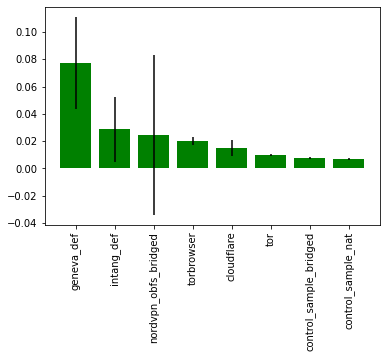

In [24]:
latencies_data_sorted = us_latencies_data_new.sort_values('ack_rtt_avg', ascending=False)
bar = plt.bar(latencies_data_sorted.index, latencies_data_sorted.ack_rtt_avg, color='green', yerr=[packet_dfs[policy].ack_rtt.var() for policy in latencies_data_sorted.index])
# figure(figsize=(10, 6), dpi=80)
# plt.savefig("test")
# lt.setp(bar.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xticks(rotation=90)
plt.savefig("latencies_us_ack_rtt_avg_new")

In [9]:
with open("egypt_latencies_data_new.csv", "w") as f:
    f.write(egypt_latencies_data_new.to_csv())

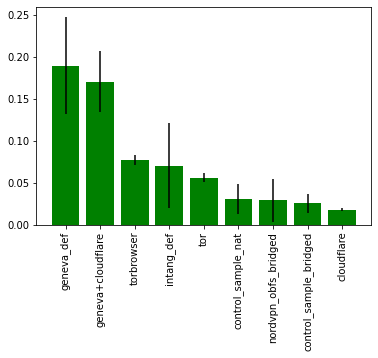

In [14]:
latencies_data_sorted = egypt_latencies_data_new.sort_values('ack_rtt_avg', ascending=False)
bar = plt.bar(latencies_data_sorted.index, latencies_data_sorted.ack_rtt_avg, color='green', yerr=[packet_dfs[policy].ack_rtt.var() for policy in latencies_data_sorted.index])
# figure(figsize=(10, 6), dpi=80)
# plt.savefig("test")
# lt.setp(bar.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xticks(rotation=90)
plt.savefig("latencies_egypt_ack_rtt_avg_new")

In [26]:
latencies = {}
for policy in policies:
    df = dfs[policy]
    masked_irtt_avg = np.ma.masked_array(df['irtt_avg'], np.isnan(df['irtt_avg']))
    masked_ack_rtt_avg = np.ma.masked_array(df['ack_rtt_avg'], np.isnan(df['ack_rtt_avg']))
    masked_ack_rtt_weighted_avg = np.ma.masked_array(df['ack_rtt_weighted_avg'], np.isnan(df['ack_rtt_weighted_avg']))
    masked_num_packets = np.ma.masked_array(df['num_packets'], np.isnan(df['num_packets']))
    latencies[policy] = {
        'irtt_avg': df['irtt_avg'].mean(),
        'irtt_weighted_avg_per_stream': np.average(masked_irtt_avg, weights=df['num_streams']),
        'irtt_weighted_avg_per_packet': np.average(masked_irtt_avg, weights=masked_num_packets),
        'ack_rtt_avg': df['ack_rtt_avg'].mean(),
        'ack_rtt_weighted_avg_per_stream': np.average(masked_ack_rtt_avg, weights=df['num_streams']),
        'ack_rtt_weighted_avg_per_packet': np.average(masked_ack_rtt_avg, weights=masked_num_packets),
        'weighted_ack_rtt_avg': df['ack_rtt_weighted_avg'].mean(),
        'weighted_ack_rtt_weighted_avg_per_stream': np.average(masked_ack_rtt_weighted_avg, weights=df['num_streams']),
        'weighted_ack_rtt_weighted_avg_per_packet': np.average(masked_ack_rtt_weighted_avg, weights=masked_num_packets),
        'crude_latency': df['crude_latency'].mean(),
        'ack_rtt_total_avg': df['ack_rtt_total_avg'].mean(),
        'ack_rtt_big_avg': df['ack_rtt_sum'].sum() / masked_num_packets.sum()
    }

In [30]:
us_latencies_data = pd.DataFrame.from_dict(latencies, orient='index')
us_latencies_data

,irtt_avg,irtt_weighted_avg_per_stream,irtt_weighted_avg_per_packet,ack_rtt_avg,ack_rtt_weighted_avg_per_stream,ack_rtt_weighted_avg_per_packet,weighted_ack_rtt_avg,weighted_ack_rtt_weighted_avg_per_stream,weighted_ack_rtt_weighted_avg_per_packet,crude_latency,ack_rtt_total_avg,ack_rtt_big_avg
control_sample_nat,0.018138,0.017911,0.016698,0.009397,0.010038,0.008920,0.007787,0.007931,0.006596,3.365370,0.003609,0.003002
control_sample_bridged,0.018467,0.017865,0.017954,0.011705,0.010075,0.009589,0.009250,0.008191,0.007582,2.442441,0.004657,0.003607
geneva_def,0.037950,0.075887,0.072466,0.026881,0.047883,0.047643,0.051688,0.069542,0.088345,2.897106,0.017680,0.030341
intang_def,0.035454,0.095963,0.053425,0.024423,0.078239,0.041544,0.019474,0.064866,0.035242,3.097887,0.006925,0.011511
nordvpn_obfs_bridged,0.088449,0.094514,0.089653,0.040827,0.071914,0.050257,0.023593,0.036608,0.021012,4.696455,0.010981,0.009000
tor,0.004721,0.005709,0.008049,0.012786,0.012226,0.012084,0.010025,0.009587,0.009099,1.365635,0.005288,0.004543
torbrowser,0.005417,0.005822,0.006112,0.017328,0.015789,0.014714,0.027838,0.025788,0.020069,3.584525,0.013057,0.008855
cloudflare,0.023403,0.039313,0.032801,0.017064,0.035209,0.027289,0.012820,0.024761,0.019068,1.938454,0.004591,0.006121


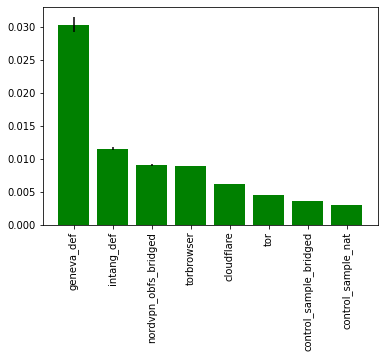

In [31]:
latencies_data_sorted = us_latencies_data.sort_values('ack_rtt_big_avg', ascending=False)
bar = plt.bar(latencies_data_sorted.index, latencies_data_sorted.ack_rtt_big_avg, color='green', yerr=[dfs[policy].ack_rtt_total_avg.var() for policy in latencies_data_sorted.index])
# figure(figsize=(10, 6), dpi=80)
# plt.savefig("test")
# lt.setp(bar.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xticks(rotation=90)
plt.savefig("latencies_us_ack_rtt_big_avg")

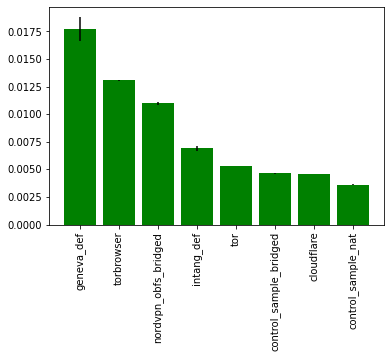

In [32]:
latencies_data_sorted = us_latencies_data.sort_values('ack_rtt_total_avg', ascending=False)
bar = plt.bar(latencies_data_sorted.index, latencies_data_sorted.ack_rtt_total_avg, color='green', yerr=[dfs[policy].ack_rtt_total_avg.var() for policy in latencies_data_sorted.index])
# figure(figsize=(10, 6), dpi=80)
# plt.savefig("test")
# lt.setp(bar.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xticks(rotation=90)
plt.savefig("latencies_us_ack_rtt_total_avg")

In [71]:
latencies = {}
for policy in policies:
    df = dfs[policy]
    masked_irtt_avg = np.ma.masked_array(df['irtt_avg'], np.isnan(df['irtt_avg']))
    masked_ack_rtt_avg = np.ma.masked_array(df['ack_rtt_avg'], np.isnan(df['ack_rtt_avg']))
    masked_ack_rtt_weighted_avg = np.ma.masked_array(df['ack_rtt_weighted_avg'], np.isnan(df['ack_rtt_weighted_avg']))
    masked_num_packets = np.ma.masked_array(df['num_packets'], np.isnan(df['num_packets']))
    latencies[policy] = {
        'irtt_avg': df['irtt_avg'].mean(),
        'irtt_weighted_avg_per_stream': np.average(masked_irtt_avg, weights=df['num_streams']),
        'irtt_weighted_avg_per_packet': np.average(masked_irtt_avg, weights=masked_num_packets),
        'ack_rtt_avg': df['ack_rtt_avg'].mean(),
        'ack_rtt_weighted_avg_per_stream': np.average(masked_ack_rtt_avg, weights=df['num_streams']),
        'ack_rtt_weighted_avg_per_packet': np.average(masked_ack_rtt_avg, weights=masked_num_packets),
        'weighted_ack_rtt_avg': df['ack_rtt_weighted_avg'].mean(),
        'weighted_ack_rtt_weighted_avg_per_stream': np.average(masked_ack_rtt_weighted_avg, weights=df['num_streams']),
        'weighted_ack_rtt_weighted_avg_per_packet': np.average(masked_ack_rtt_weighted_avg, weights=masked_num_packets),
        'crude_latency': df['crude_latency'].mean(),
        'ack_rtt_total_avg': df['ack_rtt_total_avg'].mean(),
        'ack_rtt_big_avg': df['ack_rtt_sum'].sum() / masked_num_packets.sum()
    }

In [72]:
egypt_latencies_data = pd.DataFrame.from_dict(latencies, orient='index')

In [73]:
with open("egypt_latencies_data.csv", "w") as f:
    f.write(egypt_latencies_data.to_csv())

In [78]:
egypt_latencies_data

,irtt_avg,irtt_weighted_avg_per_stream,irtt_weighted_avg_per_packet,ack_rtt_avg,ack_rtt_weighted_avg_per_stream,ack_rtt_weighted_avg_per_packet,weighted_ack_rtt_avg,weighted_ack_rtt_weighted_avg_per_stream,weighted_ack_rtt_weighted_avg_per_packet,crude_latency,ack_rtt_total_avg,ack_rtt_big_avg
control_sample_nat,0.094802,0.098100,0.097101,0.081079,0.060889,0.057496,0.056018,0.035938,0.029799,5.337057,0.024930,0.012892
control_sample_bridged,0.085957,0.086380,0.085014,0.044480,0.043609,0.041718,0.037755,0.028414,0.024537,4.517533,0.018318,0.011743
geneva_def,0.132600,0.213724,0.207267,0.085172,0.131577,0.131838,0.120674,0.169675,0.191655,4.420470,0.045182,0.071267
intang_4,0.058052,0.072551,0.071609,0.054727,0.084105,0.079393,0.053084,0.063897,0.058947,3.783389,0.007551,0.015526
intang_def,0.088801,0.143312,0.136899,0.076559,0.137766,0.124145,0.058817,0.092492,0.081874,3.473013,0.017402,0.025035
nordvpn_obfs_bridged,0.106965,0.107132,0.109416,0.049723,0.070117,0.059959,0.028483,0.035999,0.024028,5.373582,0.012917,0.010137
vpn_std_nat,0.001583,0.000998,0.000990,0.019836,0.008512,0.002516,0.006611,0.003040,0.001080,5.166501,0.001148,0.000298
tor,0.139076,0.034612,0.063189,0.055909,0.054697,0.057990,0.056746,0.055353,0.055250,3.233535,0.032365,0.030565
torbrowser,0.156307,0.156307,0.156271,0.076676,0.076676,0.076826,0.076676,0.076676,0.076826,0.459994,0.044594,0.044621
cloudflare,0.072604,0.071122,0.074931,0.035949,0.032621,0.025859,0.032256,0.023068,0.015585,4.645156,0.014812,0.007589


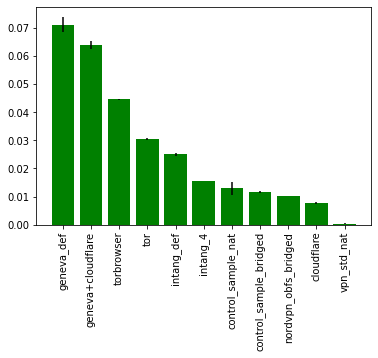

In [80]:
latencies_data_sorted = egypt_latencies_data.sort_values('ack_rtt_big_avg', ascending=False)
bar = plt.bar(latencies_data_sorted.index, latencies_data_sorted.ack_rtt_big_avg, color='green', yerr=[dfs[policy].ack_rtt_total_avg.var() for policy in latencies_data_sorted.index])
# figure(figsize=(10, 6), dpi=80)
# plt.savefig("test")
# lt.setp(bar.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xticks(rotation=90)
plt.savefig("latencies_egypt_ack_rtt_big_avg")

In [32]:
us_latencies_data = pd.DataFrame.from_dict(latencies, orient='index')
us_latencies_data

,irtt_avg,irtt_weighted_avg_per_stream,irtt_weighted_avg_per_packet,ack_rtt_avg,ack_rtt_weighted_avg_per_stream,ack_rtt_weighted_avg_per_packet,weighted_ack_rtt_avg,weighted_ack_rtt_weighted_avg_per_stream,weighted_ack_rtt_weighted_avg_per_packet,crude_latency
control_sample_nat,0.018138,0.017911,0.016698,0.009397,0.010038,0.008920,0.007787,0.007931,0.006596,3.365370
control_sample_bridged,0.018467,0.017865,0.017954,0.011705,0.010075,0.009589,0.009250,0.008191,0.007582,2.442441
geneva_def,0.037950,0.075887,0.072466,0.026881,0.047883,0.047643,0.051688,0.069542,0.088345,2.897106
intang_4,0.025203,0.049628,0.042270,0.020086,0.044137,0.035303,0.013924,0.031184,0.024350,1.712804
intang_def,0.035454,0.095963,0.053425,0.024423,0.078239,0.041544,0.019474,0.064866,0.035242,3.097887
nordvpn_obfs_bridged,0.088449,0.094514,0.089653,0.040827,0.071914,0.050257,0.023593,0.036608,0.021012,4.696455
vpn_std_nat,0.000583,0.000568,0.000576,0.000322,0.000486,0.000401,0.000330,0.000460,0.000378,4.497602
tor,0.004721,0.005709,0.008049,0.012786,0.012226,0.012084,0.010025,0.009587,0.009099,1.365635
torbrowser,0.005417,0.005822,0.006112,0.017328,0.015789,0.014714,0.027838,0.025788,0.020069,3.584525
cloudflare,0.023403,0.039313,0.032801,0.017064,0.035209,0.027289,0.012820,0.024761,0.019068,1.938454


In [33]:
with open("us_latencies_data.csv", "w") as f:
    f.write(us_latencies_data.to_csv())

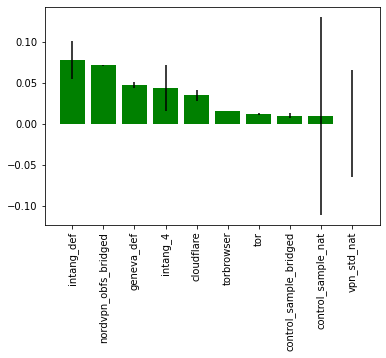

In [68]:
latencies_data_sorted = us_latencies_data.sort_values('ack_rtt_weighted_avg_per_stream', ascending=False)
bar = plt.bar(latencies_data_sorted.index, latencies_data_sorted.ack_rtt_weighted_avg_per_stream, color='green', yerr=[dfs[policy].ack_rtt_avg.var() for policy in latencies_data_sorted.index])
# figure(figsize=(10, 6), dpi=80)
# plt.savefig("test")
# lt.setp(bar.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xticks(rotation=90)
plt.savefig("latencies_us_ack_rtt_weighted_avg_per_stream")

In [74]:
latencies_data.weighted_ack_rtt_weighted_avg_per_stream.var()
[dfs[policy].ack_rtt_weighted_avg.var() for policy in policies]

NameError: name 'latencies_data' is not defined

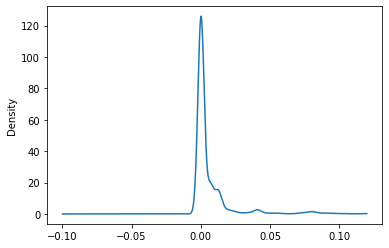

In [96]:
tor_data = packet_dfs['tor']
control_data = packet_dfs['control_sample_bridged']
control_plot = control_data.ack_rtt.plot.kde(ind=np.arange(-0.1,0.12,0.0001))

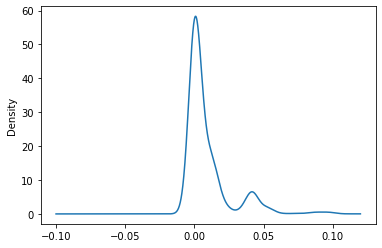

In [97]:
# packet_dfs['control_sample_bridged'].ack_rtt.plot.kde(ind=np.arange(-0.1, 0.12, 0.0001))
# df = pd.DataFrame({
#     'control': list(control_data.ack_rtt),
#     'tor': list(tor_data.ack_rtt),
# })
tor_plot = tor_data.ack_rtt.plot.kde(ind=np.arange(-0.1,0.12,0.0001))


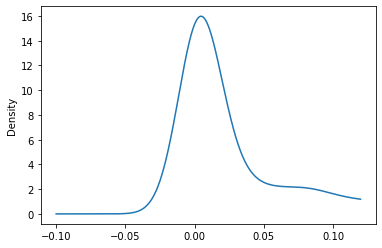

In [113]:
geneva_data = packet_dfs['geneva_def']
geneva_plot = packet_dfs['geneva_def'].ack_rtt.plot.kde(ind=np.arange(-0.1,0.12,0.0001))

In [136]:
geneva_data = packet_dfs['geneva_def']
torbrowser_data = packet_dfs['torbrowser']
max_len = max(len(list(geneva_data.initial_rtt)), len(list(torbrowser_data.initial_rtt)), len(list(control_data.initial_rtt)))
df = pd.DataFrame.from_dict({
    'geneva': list(geneva_data.initial_rtt) + ([None] * (max_len - len(geneva_data.initial_rtt))),
    'torbrowser': list(torbrowser_data.initial_rtt) + ([None] * (max_len - len(torbrowser_data.initial_rtt))),
    'control': list(control_data.initial_rtt) + ([None] * (max_len-len(control_data.initial_rtt)))
})

<AxesSubplot:ylabel='Density'>

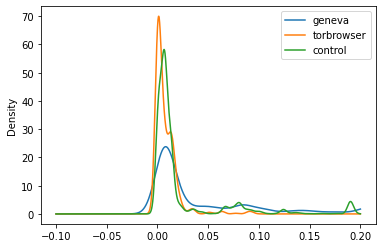

In [137]:
df.plot.kde(ind=np.arange(-0.1,0.20,0.0001))